# Apply painter style to your photo 📸

In [1]:
import tensorflow as tf
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (16,16)
mpl.rcParams['axes.grid'] = False

import numpy as np
import time
import functools

In [2]:
content_path = tf.keras.utils.get_file('belfry.jpg','https://storage.googleapis.com/khanhlvg-public.appspot.com/arbitrary-style-transfer/belfry-2611573_1280.jpg')
selected_style = 'van_gogh_starry_night'

In [3]:
# Function to load an image from a file, and add a batch dimension.
def load_img(path_to_img):
    img = tf.io.read_file(path_to_img)
    img = tf.io.decode_image(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = img[tf.newaxis, :]

    return img

# Function to pre-process by resizing an central cropping it.
def preprocess_image(image, target_dim):
    # Resize the image so that the shorter dimension becomes 256px.
    shape = tf.cast(tf.shape(image)[1:-1], tf.float32)
    short_dim = min(shape)
    scale = target_dim / short_dim
    new_shape = tf.cast(shape * scale, tf.int32)
    image = tf.image.resize(image, new_shape)

    # Central crop the image.
    image = tf.image.resize_with_crop_or_pad(image, target_dim, target_dim)

    return image

def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    plt.axis('off')
    if title:
        plt.title(title)

In [4]:


style_predict_path = tf.keras.utils.get_file('style_predict.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/prediction/1?lite-format=tflite')
style_transform_path = tf.keras.utils.get_file('style_transform.tflite', 'https://tfhub.dev/google/lite-model/magenta/arbitrary-image-stylization-v1-256/int8/transfer/1?lite-format=tflite')

In [5]:
style_urls = dict(
  kanagawa_great_wave='https://upload.wikimedia.org/wikipedia/commons/0/0a/The_Great_Wave_off_Kanagawa.jpg',
  kandinsky_composition_7='https://upload.wikimedia.org/wikipedia/commons/b/b4/Vassily_Kandinsky%2C_1913_-_Composition_7.jpg',
  hubble_pillars_of_creation='https://upload.wikimedia.org/wikipedia/commons/6/68/Pillars_of_creation_2014_HST_WFC3-UVIS_full-res_denoised.jpg',
  van_gogh_starry_night='https://upload.wikimedia.org/wikipedia/commons/thumb/e/ea/Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg/1024px-Van_Gogh_-_Starry_Night_-_Google_Art_Project.jpg',
  #turner_nantes='https://upload.wikimedia.org/wikipedia/commons/b/b7/JMW_Turner_-_Nantes_from_the_Ile_Feydeau.jpg',
  munch_scream='https://upload.wikimedia.org/wikipedia/commons/c/c5/Edvard_Munch%2C_1893%2C_The_Scream%2C_oil%2C_tempera_and_pastel_on_cardboard%2C_91_x_73_cm%2C_National_Gallery_of_Norway.jpg',
  picasso_demoiselles_avignon='https://upload.wikimedia.org/wikipedia/en/4/4c/Les_Demoiselles_d%27Avignon.jpg',
  picasso_violin='https://upload.wikimedia.org/wikipedia/en/3/3c/Pablo_Picasso%2C_1911-12%2C_Violon_%28Violin%29%2C_oil_on_canvas%2C_Kr%C3%B6ller-M%C3%BCller_Museum%2C_Otterlo%2C_Netherlands.jpg',
  #picasso_bottle_of_rum='https://upload.wikimedia.org/wikipedia/en/7/7f/Pablo_Picasso%2C_1911%2C_Still_Life_with_a_Bottle_of_Rum%2C_oil_on_canvas%2C_61.3_x_50.5_cm%2C_Metropolitan_Museum_of_Art%2C_New_York.jpg',
  fire='https://upload.wikimedia.org/wikipedia/commons/3/36/Large_bonfire.jpg',
  derkovits_woman_head='https://upload.wikimedia.org/wikipedia/commons/0/0d/Derkovits_Gyula_Woman_head_1922.jpg',
  amadeo_style_life='https://upload.wikimedia.org/wikipedia/commons/8/8e/Untitled_%28Still_life%29_%281913%29_-_Amadeo_Souza-Cardoso_%281887-1918%29_%2817385824283%29.jpg',
  derkovtis_talig='https://upload.wikimedia.org/wikipedia/commons/3/37/Derkovits_Gyula_Talig%C3%A1s_1920.jpg',
  amadeo_cardoso='https://upload.wikimedia.org/wikipedia/commons/7/7d/Amadeo_de_Souza-Cardoso%2C_1915_-_Landscape_with_black_figure.jpg'
)

## Available styles 🎨

2022-02-15 14:29:07.498568: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


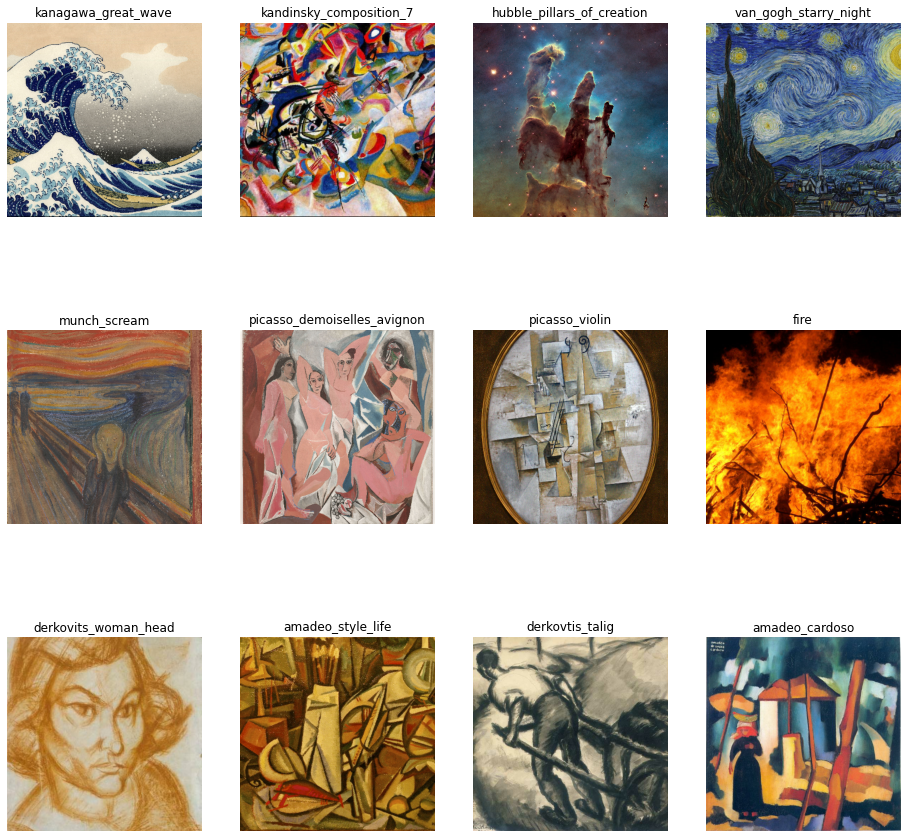

In [6]:
for i, (k,v) in enumerate(style_urls.items()):
    style_path = tf.keras.utils.get_file(k, v)
    style_image = load_img(style_path)
    preprocessed_style_image = preprocess_image(style_image, 384)
    
    plt.subplot(3, 4, i+1)
    imshow(preprocessed_style_image, k)

In [7]:
style_path = tf.keras.utils.get_file(selected_style, style_urls[selected_style])

In [8]:
# Load the input images.
content_image = load_img(content_path)
style_image = load_img(style_path)

# Preprocess the input images.
preprocessed_content_image = preprocess_image(content_image, 384)
preprocessed_style_image = preprocess_image(style_image, 256)


In [9]:
# Function to run style prediction on preprocessed style image.
def run_style_predict(preprocessed_style_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=style_predict_path)

    # Set model input.
    interpreter.allocate_tensors()
    input_details = interpreter.get_input_details()
    interpreter.set_tensor(input_details[0]["index"], preprocessed_style_image)

    # Calculate style bottleneck.
    interpreter.invoke()
    style_bottleneck = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return style_bottleneck

# Calculate style bottleneck for the preprocessed style image.
# style_bottleneck = run_style_predict(preprocessed_style_image)

In [10]:
# Run style transform on preprocessed style image
def run_style_transform(style_bottleneck, preprocessed_content_image):
    # Load the model.
    interpreter = tf.lite.Interpreter(model_path=style_transform_path)

    # Set model input.
    input_details = interpreter.get_input_details()
    interpreter.allocate_tensors()

    # Set model inputs.
    interpreter.set_tensor(input_details[0]["index"], preprocessed_content_image)
    interpreter.set_tensor(input_details[1]["index"], style_bottleneck)
    interpreter.invoke()

    # Transform content image.
    stylized_image = interpreter.tensor(
      interpreter.get_output_details()[0]["index"]
      )()

    return stylized_image

# Stylize the content image using the style bottleneck.
# stylized_image = run_style_transform(style_bottleneck, preprocessed_content_image)



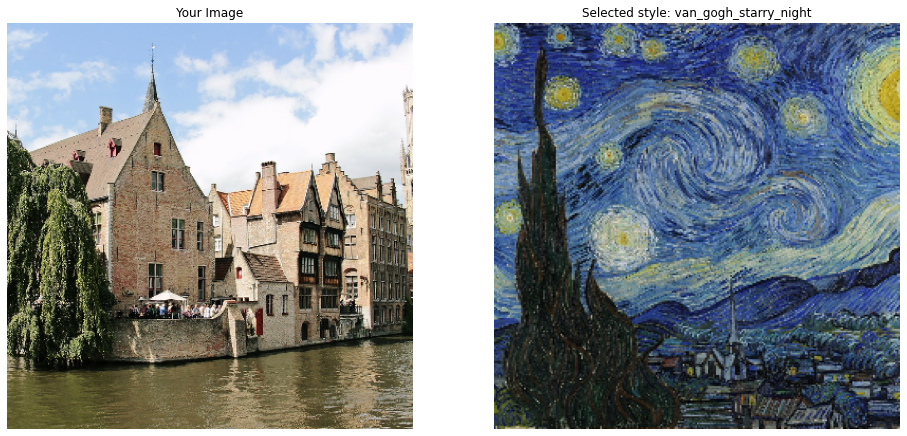

In [11]:
plt.subplot(1, 2, 1)
imshow(preprocessed_content_image, 'Your Image')

plt.subplot(1, 2, 2)
imshow(preprocessed_style_image, f'Selected style: {selected_style}')

In [12]:
# Visualize the output.
# imshow(stylized_image, 'Stylized Image')